# Vision Experiments

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo
import lightning as L
from lightning.pytorch.loggers.wandb import WandbLogger
import torchmetrics

import wandb

import sys; sys.path.append('../..')
from vision_models import ViT, VAT, configure_optimizers
from utils.pl_tqdm_progbar import TQDMProgressBar

## Config

In [2]:
print('cuda available: ', torch.cuda.is_available())
print('device count: ', torch.cuda.device_count())
print('current device name: ', torch.cuda.get_device_name(torch.cuda.current_device()))
print('Memory Usage:')
print('\tAllocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('\tReserved:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

cuda available:  True
device count:  1
current device name:  NVIDIA GeForce RTX 4070 Laptop GPU
Memory Usage:
	Allocated: 0.0 GB
	Reserved:    0.0 GB


In [3]:
device = 'cuda'
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast

dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

# optimization hyperparams
learning_rate = 1e-3 # with baby networks can afford to go a bit higher
# max_iters = 5000
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
decay_lr = True # whether to decay the learning rate
lr_decay_iters = 5000 # make equal to max_iters usually
weight_decay = 1e-1
min_lr = 1e-4 # learning_rate / 10 usually
beta1 = 0.9
beta2 = 0.99 # make a bit bigger because number of tokens per iter is small
# warmup_iters = 100
gradient_accumulation_steps = 1 # accumulate gradients over this many steps. simulates larger batch size


## Data

In [4]:
# load CIFAR10 data

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_classes = 10
assert n_classes == len(classes)

Files already downloaded and verified
Files already downloaded and verified


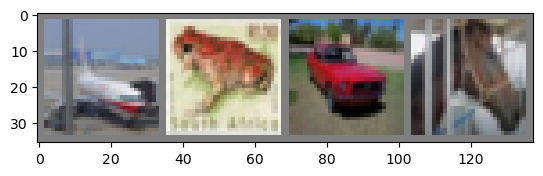

plane frog  car   horse


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Define Pytorch Lightning Module

In [6]:
for x in train_dataloader:
    # print(x)
    print(x[0].shape)
    print(x[1].shape)
    # print(len(x))
    break

torch.Size([4, 3, 32, 32])
torch.Size([4])


In [7]:
log_on_step = True

class LitVisionModel(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = torch.nn.functional.cross_entropy
        self.accuracy = lambda pred, y: torchmetrics.functional.accuracy(pred, y, task="multiclass", num_classes=n_classes, top_k=1, average='micro')

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits, y)

        self.log('train/loss', loss, prog_bar=True, logger=True, on_step=log_on_step, on_epoch=True)
        self.log('train/acc', acc, prog_bar=True, logger=True, on_step=log_on_step, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits, y)

        self.log(f"val/loss", loss, prog_bar=True, logger=True, add_dataloader_idx=False)
        self.log(f"val/acc", acc, prog_bar=True, logger=True, add_dataloader_idx=False)

    def test_step(self, batch, batch_idx):
        x, y = batch

        logits = self.model(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits, y)

        self.log(f"test/loss", loss, prog_bar=True, logger=True, add_dataloader_idx=False)
        self.log(f"test/acc", acc, prog_bar=True, logger=True, add_dataloader_idx=False)


    def configure_optimizers(self):
        optimizer = configure_optimizers(self.model, weight_decay, learning_rate, (beta1, beta2), device_type=device)
        return optimizer

# endregion


## Create Model

In [8]:
c, w, h = images.shape[1:]
image_shape = (c, w, h)

In [9]:
# model args
symbol_type = 'pos_relative'
d_model, n_layers, dff = 256, 4, None
sa, rca = 4, 0
patch_size = (4, 4)
n_patches = (w // patch_size[0]) * (h // patch_size[1])
activation = 'gelu'
dropout_rate = 0.1
disentangled_rca = True
norm_first = True
bias = False
pool = 'cls'

In [10]:
# define kwargs for symbol-retrieval module based on type
rca_kwargs = dict()
if symbol_type == 'sym_attn':
    symbol_retrieval_kwargs = dict(d_model=d_model, n_symbols=50, n_heads=4) # NOTE: n_heads, n_symbols fixed for now
elif symbol_type == 'pos_sym_retriever':
    symbol_retrieval_kwargs = dict(symbol_dim=d_model, max_length=n_patches+1)
elif symbol_type == 'pos_relative':
    symbol_retrieval_kwargs = dict(symbol_dim=d_model, max_rel_pos=n_patches+1)
    rca_kwargs['use_relative_positional_symbols'] = True # if using position-relative symbols, need to tell RCA module
elif rca != 0:
    raise ValueError(f'`symbol_type` {symbol_type} not valid')

# if rca=0, use TransformerLM
if rca == 0:
    model_args = dict(
        image_shape=image_shape, patch_size=patch_size, num_classes=n_classes, pool=pool,
        d_model=d_model, n_layers=n_layers, n_heads=sa, dff=dff, dropout_rate=dropout_rate,
        activation=activation, norm_first=norm_first, bias=bias)

    model = transformer_lm = ViT(**model_args).to(device)
# otherwise, use AbstractTransformerLM
else:
    model_args = dict(
        image_shape=image_shape, patch_size=patch_size, num_classes=n_classes, pool=pool,
        d_model=d_model, n_layers=n_layers, n_heads_sa=sa, n_heads_rca=rca, dff=dff, dropout_rate=dropout_rate,
        activation=activation, norm_first=norm_first, bias=bias, 
        symbol_retrieval=symbol_type, symbol_retrieval_kwargs=symbol_retrieval_kwargs, rca_kwargs=rca_kwargs)

    model = abstracttransformer_lm = VAT(**model_args).to(device)

print(torchinfo.summary(
    model, input_size=(1, *image_shape),
    col_names=("input_size", "output_size", "num_params", "params_percent")))


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %
ViT                                      [1, 3, 32, 32]            [1, 10]                   16,896                      0.53%
├─Sequential: 1-1                        [1, 3, 32, 32]            [1, 64, 256]              --                             --
│    └─Rearrange: 2-1                    [1, 3, 32, 32]            [1, 64, 48]               --                             --
│    └─LayerNorm: 2-2                    [1, 64, 48]               [1, 64, 48]               96                          0.00%
│    └─Linear: 2-3                       [1, 64, 48]               [1, 64, 256]              12,544                      0.39%
│    └─LayerNorm: 2-4                    [1, 64, 256]              [1, 64, 256]              512                         0.02%
├─Dropout: 1-2                           [1, 65, 256]              [1, 65, 256]              --                

In [11]:
lit_model = LitVisionModel(model)

## Train Model

In [12]:
log_to_wandb = False
n_epochs = 1
max_steps = -1
log_every_n_steps = 20
eval_interval = None

In [13]:
if log_to_wandb:
    run = wandb.init(project=wandb_project, group=group_name, name=run_name,
        config={'group': group_name, 'num_params': num_params, **model_args})

    wandb_logger = WandbLogger(experiment=run, log_model=log_model),
else:
    wandb_logger = None

callbacks = [
    TQDMProgressBar(refresh_rate=50)
]

trainer_kwargs = dict(
    max_epochs=n_epochs, enable_checkpointing=False, enable_model_summary=True, benchmark=True,
    enable_progress_bar=True, callbacks=callbacks, logger=wandb_logger,
    accumulate_grad_batches=gradient_accumulation_steps, gradient_clip_val=grad_clip,
    log_every_n_steps=log_every_n_steps, max_steps=max_steps, val_check_interval=eval_interval)

trainer = L.Trainer(
    **trainer_kwargs
    )
trainer.fit(model=lit_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
# endregion


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-04-15 18:28:02.980214: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 18:28:03.945999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when 

num decayed parameter tensors: 28, with 3,177,472 parameters
num non-decayed parameter tensors: 22, with 4,970 parameters
using fused AdamW: True
Epoch 0: 100%|██████████| 12500/12500 [05:16<00:00, 39.54it/s, v_num=3, train/loss_step=1.980, train/acc_step=0.250, val/loss=1.940, val/acc=0.273, train/loss_epoch=2.220, train/acc_epoch=0.206]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12500/12500 [05:16<00:00, 39.54it/s, v_num=3, train/loss_step=1.980, train/acc_step=0.250, val/loss=1.940, val/acc=0.273, train/loss_epoch=2.220, train/acc_epoch=0.206]
